# Лабороторная работа 2. Ассоциативные правила

## Цель работы
исследование методов анализа ассоциативных правил.

## Задачи
+ Загрузить датасет из репозитория (например, kaggle.com или аналогичных платформ). Данные должны представлять собой информацию о купленных вместе товарах .

+ Привести описание данных из датасета: график вывода длин транзакций, список уникальных товаров и др. 

+ Алгоритм Apriori: выполнить анализ ассоциативных правил при помощи алгоритма Apriori с изначальными условиями в соответствии с вариантом задания. Проанализировать полученные результаты, выделив полезные и тривиальные правила, и оценив значение достоверности, лифта правил. Провести оценку влияния параметров алгоритма на получаемые правила (на количество правил и метрики).

+ Алгоритм FPG: провести анализ правил, используя алгоритм FPG. В отчете привести правила, получившиеся в результате использования данного алгоритма.

+ Алгоритмически определить минимальные значения поддержки для составления правил из 1, 2, и т.д. объектов в одном из алгоритмов.

+ Последовательно меняя параметры (значения поддержки и достоверности) одного из алгоритмов получить наборы ассоциативных правил. Сделать выводы на основе проведенных экспериментов.

+ Проанализировать получающийся в результате работы программы граф. Объяснить, какую информацию можно из него извлечь.

+ Предложить и реализовать свой способ визуализации ассоциативных правил и метрик.

## Загрузка датасета
Для анализа был выбран датасет [Online Retail Data Set from ML Repository](https://www.kaggle.com/datasets/mathchi/online-retail-data-set-from-ml-repository)


In [73]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
import networkx as nx


all_data = pd.read_csv('groceries - groceries.csv')
print(all_data.head())

   Item(s)            Item 1               Item 2          Item 3  \
0        4      citrus fruit  semi-finished bread       margarine   
1        3    tropical fruit               yogurt          coffee   
2        1        whole milk                  NaN             NaN   
3        4         pip fruit               yogurt    cream cheese   
4        4  other vegetables           whole milk  condensed milk   

                     Item 4 Item 5 Item 6 Item 7 Item 8 Item 9  ... Item 23  \
0               ready soups    NaN    NaN    NaN    NaN    NaN  ...     NaN   
1                       NaN    NaN    NaN    NaN    NaN    NaN  ...     NaN   
2                       NaN    NaN    NaN    NaN    NaN    NaN  ...     NaN   
3              meat spreads    NaN    NaN    NaN    NaN    NaN  ...     NaN   
4  long life bakery product    NaN    NaN    NaN    NaN    NaN  ...     NaN   

  Item 24 Item 25 Item 26 Item 27 Item 28 Item 29 Item 30 Item 31 Item 32  
0     NaN     NaN     NaN     NaN 

## Анализ данных

### Описание датасета
Данный датасет представляет собой список товаров, приобретённых в рамках одной покупки (чека). В нём присутствуют как продовольственные, так и непродовольственные (бытовые) товары.

### График вывода длин транзакций


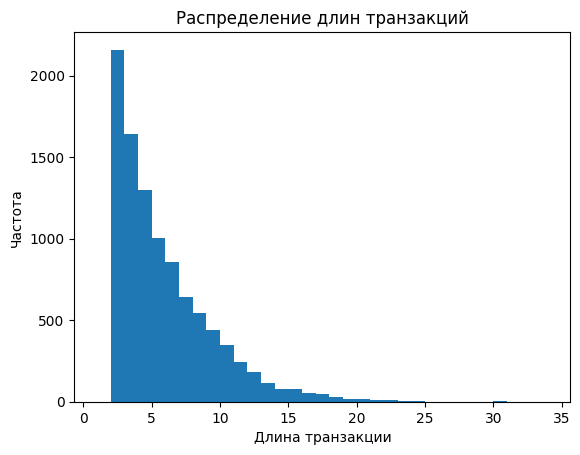

In [74]:
transaction_lengths = all_data.notnull().sum(axis=1)
plt.hist(transaction_lengths, bins=range(1, max(transaction_lengths) + 2))
plt.xlabel('Длина транзакции')
plt.ylabel('Частота')
plt.title('Распределение длин транзакций')
plt.show()
#Очистка данных
np_data = all_data.to_numpy()
np_data = [[elem for elem in row[1:] if isinstance(elem,str)] for row in np_data]

На основе полученного графика для длин транзакций можем сделать вывод о том, что в среднем за одну покупку преобретается от 3 до 9 товаров. Чаще приобретают 3 товара.
### Уникальные товары


In [75]:
unique_items = set()
for row in np_data:
    for elem in row:
        unique_items.add(elem)
print(unique_items)


{'sparkling wine', 'specialty vegetables', 'sugar', 'hygiene articles', 'pasta', 'artif. sweetener', 'cream cheese', 'syrup', 'waffles', 'cocoa drinks', 'turkey', 'white bread', 'long life bakery product', 'chewing gum', 'cream', 'rubbing alcohol', 'chicken', 'flower (seeds)', 'shopping bags', 'kitchen towels', 'soda', 'seasonal products', 'jam', 'canned fish', 'house keeping products', 'brandy', 'cooking chocolate', 'roll products', 'snack products', 'specialty fat', 'chocolate', 'grapes', 'specialty chocolate', 'specialty bar', 'frozen chicken', 'soups', 'misc. beverages', 'semi-finished bread', 'rolls/buns', 'frozen dessert', 'frozen fruits', 'condensed milk', 'packaged fruit/vegetables', 'butter', 'pastry', 'instant coffee', 'canned fruit', 'curd', 'napkins', 'decalcifier', 'dessert', 'honey', 'mayonnaise', 'oil', 'cling film/bags', 'mustard', 'newspapers', 'organic sausage', 'baby cosmetics', 'meat spreads', 'frozen vegetables', 'female sanitary products', 'potted plants', 'toilet

## Алгоритм FPG


### Шаг 1: Первый проход — подсчёт частоты
+ Сканируем все транзакции.
+ Подсчитываем, сколько раз каждый отдельный товар встречается (его поддержка).
+ Удаляем редкие товары (те, у кого поддержка < min_support).
+ Оставшиеся товары сортируем по убыванию частоты.
### Шаг 2: Построение FP-дерева
+ Проходим по транзакциям ещё раз.
+ Для каждой транзакции оставляем только частые товары и сортируем их по частоте (как на шаге 1).
+ Добавляем эту последовательность в FP-дерево — иерархическую структуру, где:
    - Каждый узел = товар + счётчик (сколько раз путь прошёл через него).
    - Общие префиксы путей объединяются (экономия памяти).
    - Также строится таблица заголовков (header table), указывающая на все узлы с данным товаром.
### Шаг 3: Генерация частых наборов (без генерации кандидатов!)
+ Для каждого частого товара (в порядке убывания частоты) строится его условная база — набор путей в дереве, ведущих к этому товару.
+ На основе условной базы строится условное FP-дерево.
+ Рекурсивно извлекаются частые наборы, содержащие этот товар.
+ Таким образом, находятся все частые наборы, не генерируя лишних кандидатов.

Частые наборы(FPG):
     support                             itemsets
0   0.082766                       (citrus fruit)
1   0.058566                          (margarine)
2   0.139502                             (yogurt)
3   0.104931                     (tropical fruit)
4   0.058058                             (coffee)
..       ...                                  ...
58  0.033249                 (whole milk, pastry)
59  0.047382  (root vegetables, other vegetables)
60  0.048907        (root vegetables, whole milk)
61  0.030605                (rolls/buns, sausage)
62  0.032232     (whipped/sour cream, whole milk)

[63 rows x 2 columns]
Количество правил: 14
       antecedents_str   consequents_str   support  confidence      lift
6     other vegetables        whole milk  0.074835    0.386758  1.513634
7           rolls/buns        whole milk  0.056634    0.307905  1.205032
1               yogurt        whole milk  0.056024    0.401603  1.571735
11     root vegetables        whole milk  0

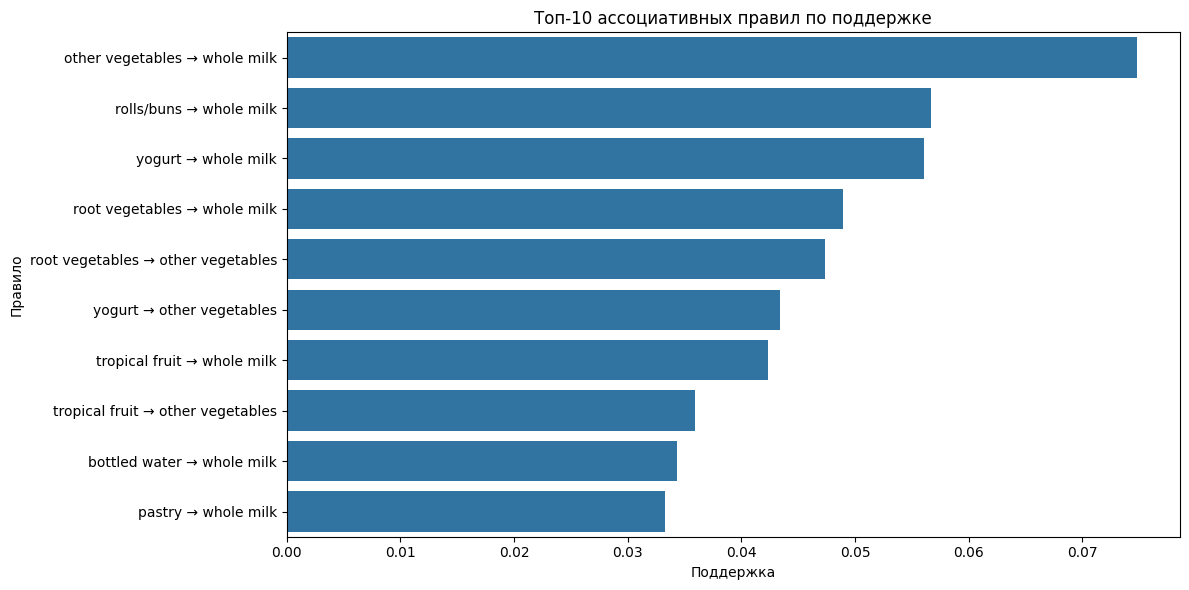

In [76]:
te = TransactionEncoder()
te_ary = te.fit(np_data).transform(np_data)
data = pd.DataFrame(te_ary, columns=te.columns_)


df1 = fpgrowth(data, min_support=0.03, use_colnames = True)
print('Частые наборы(FPG):')
print(df1)

rules = association_rules(df1, metric = "confidence", min_threshold = 0.3)

rules['antecedent_len'] = rules['antecedents'].apply(lambda x: len(x))
rules['consequent_len'] = rules['consequents'].apply(lambda x: len(x))

rules_filtered = rules[(rules['antecedent_len'] + rules['consequent_len']) >= 2]
rules_filtered = rules_filtered.sort_values(by='support', ascending=False)

rules_filtered['antecedents_str'] = rules_filtered['antecedents'].apply(lambda x: ', '.join(list(x)))
rules_filtered['consequents_str'] = rules_filtered['consequents'].apply(lambda x: ', '.join(list(x)))
print('Количество правил:', len(rules_filtered))
print(rules_filtered[['antecedents_str', 'consequents_str', 'support', 'confidence', 'lift']])

rules_filtered['rule_str'] = rules_filtered['antecedents_str'] + ' → ' + rules_filtered['consequents_str']

top_rules = rules_filtered.nlargest(10, 'support')

plt.figure(figsize=(12, 6))
sns.barplot(x='support', y='rule_str', data=top_rules)
plt.title('Топ-10 ассоциативных правил по поддержке')
plt.xlabel('Поддержка')
plt.ylabel('Правило')
plt.tight_layout()
plt.show()

На основе полученных данных мы видем что в 7%(support = 0.07) случаях вместе с овощами преобретают молоко.
Часто вместе с корнеплодами преобретают другие овощи (lift = 2.25).
Также можно увидеть, что вместе с фруктами также покупают молоко(lift = 1.44 и lift = 1.55).
Также можно увидеть, что вместе с сосисками покупают булочки, что похоже на набор для хот-дога.
## Алгоритм Apriori


Частые наборы(Apriori):
     support                          itemsets
0   0.033452                        (UHT-milk)
1   0.052466                            (beef)
2   0.033249                         (berries)
3   0.080529                    (bottled beer)
4   0.110524                   (bottled water)
..       ...                               ...
58  0.048907     (root vegetables, whole milk)
59  0.040061                (whole milk, soda)
60  0.042298      (whole milk, tropical fruit)
61  0.032232  (whipped/sour cream, whole milk)
62  0.056024              (whole milk, yogurt)

[63 rows x 2 columns]
Количество правил: 14
       antecedents_str   consequents_str   support  confidence      lift
4     other vegetables        whole milk  0.074835    0.386758  1.513634
9           rolls/buns        whole milk  0.056634    0.307905  1.205032
13              yogurt        whole milk  0.056024    0.401603  1.571735
10     root vegetables        whole milk  0.048907    0.448694  1.756031
2 

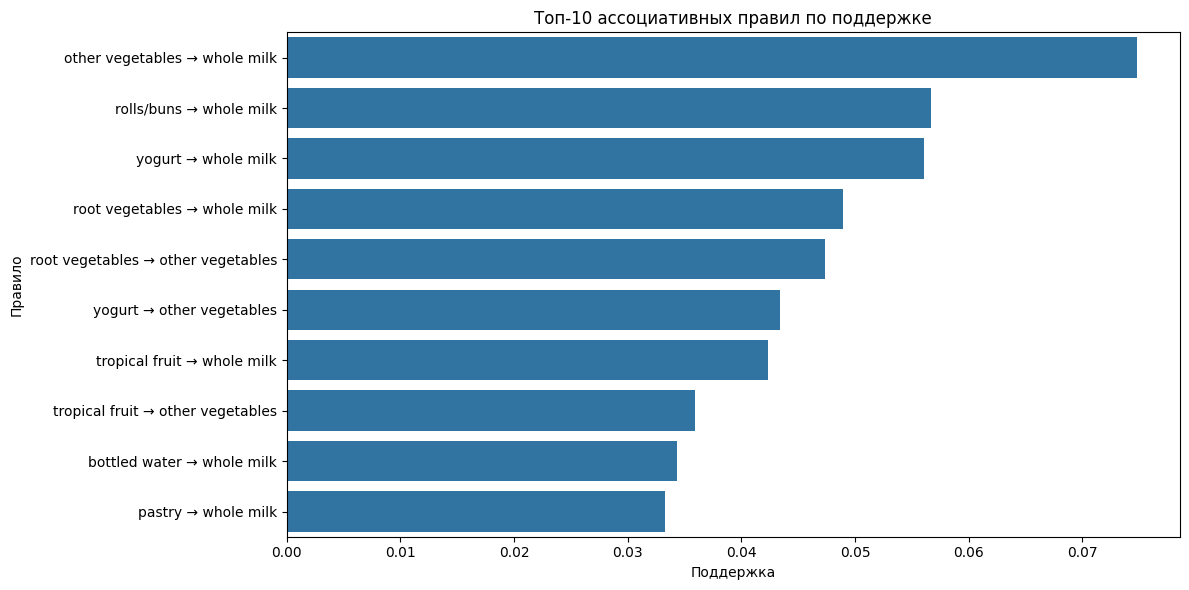

In [77]:
df1 = apriori(data, min_support=0.03, use_colnames = True)
print('Частые наборы(Apriori):')
print(df1)

rules = association_rules(df1, metric = "confidence", min_threshold = 0.3)

rules['antecedent_len'] = rules['antecedents'].apply(lambda x: len(x))
rules['consequent_len'] = rules['consequents'].apply(lambda x: len(x))

rules_filtered = rules[(rules['antecedent_len'] + rules['consequent_len']) >= 2]
rules_filtered = rules_filtered.sort_values(by='support', ascending=False)

rules_filtered['antecedents_str'] = rules_filtered['antecedents'].apply(lambda x: ', '.join(list(x)))
rules_filtered['consequents_str'] = rules_filtered['consequents'].apply(lambda x: ', '.join(list(x)))
print('Количество правил:', len(rules_filtered))
print(rules_filtered[['antecedents_str', 'consequents_str', 'support', 'confidence', 'lift']])

rules_filtered['rule_str'] = rules_filtered['antecedents_str'] + ' → ' + rules_filtered['consequents_str']

top_rules = rules_filtered.nlargest(10, 'support')

plt.figure(figsize=(12, 6))
sns.barplot(x='support', y='rule_str', data=top_rules)
plt.title('Топ-10 ассоциативных правил по поддержке')
plt.xlabel('Поддержка')
plt.ylabel('Правило')
plt.tight_layout()
plt.show()

На основе получившигося значения lift разобьем правила на тривиальные (lift < 1.3>) и полезные(lift > 1.5).

Тривиальные правила
+ bottled water - whole milk (support = 0.034, confidence = 0.311, lift = 1.22)
+ rolls/buns - whole milk (support = 0.057, confidence = 0.308, lift = 1.21)
Полезные правила
+ root vegetables - other vegetables (support = 0.047, confidence = 0.435, lift = 2.25)
+ sausage - rolls/buns (support = 0.031, confidence = 0.326, lift = 1.77)
+ whipped/sour cream - whole milk (support = 0.032, confidence = 0.450, lift = 1.76)
+ root vegetables - whole milk (support = 0.049, confidence = 0.449, lift = 1.76)
+ tropical fruit - other vegetables (support = 0.036, confidence = 0.342, lift = 1.77)
+ tropical fruit - whole milk (support = 0.042, confidence = 0.403, lift = 1.58)
+ yogurt - whole milk (support = 0.056, confidence = 0.402, lift = 1.57)
+ pip fruit - whole milk (support = 0.030, confidence = 0.398, lift = 1.56)
+ other vegetables - whole milk (support = 0.075, confidence = 0.387, lift = 1.51)
+ yogurt - other vegetables (support = 0.043, confidence = 0.311, lift = 1.61)
+ pastry - whole milk (support = 0.033, confidence = 0.374, lift = 1.46)

При принятие решений стоит выбирать правила с высоким значением lift, так как этот параметр насколько часто эти продукты покупают вместе. И не стоит использовать тривиальные правила.

## График достоверности

C:\Users\eavde\AppData\Local\Temp\ipykernel_11572\542158766.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='confidence', y='rule_str', data=top_rules, palette='viridis')


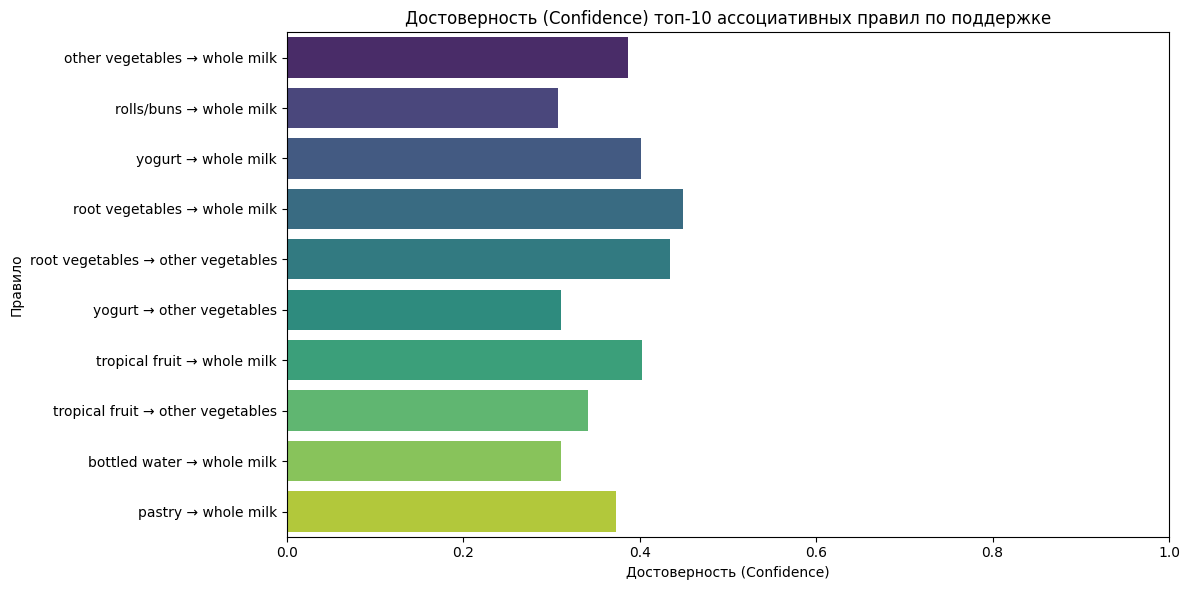

In [78]:
plt.figure(figsize=(12, 6))
sns.barplot(x='confidence', y='rule_str', data=top_rules, palette='viridis')
plt.title('Достоверность (Confidence) топ-10 ассоциативных правил по поддержке')
plt.xlabel('Достоверность (Confidence)')
plt.ylabel('Правило')
plt.xlim(0, 1)  # confidence в диапазоне [0, 1]
plt.tight_layout()
plt.show()

## Определение максимальной поддержки для составления правил разной длины


In [79]:
df_all = apriori(data, min_support=0.001, use_colnames=True)

df_all['length'] = df_all['itemsets'].apply(lambda x: len(x))

max_support_by_length = df_all.groupby('length')['support'].max()

print("Максимальная поддержка для itemsets разной длины:")
for length, max_sup in max_support_by_length.items():
    print(f"Длина {length}: max_support = {max_sup:.6f} ({max_sup * 100:.3f}%)")

Максимальная поддержка для itemsets разной длины:
Длина 1: max_support = 0.255516 (25.552%)
Длина 2: max_support = 0.074835 (7.483%)
Длина 3: max_support = 0.023183 (2.318%)
Длина 4: max_support = 0.007829 (0.783%)
Длина 5: max_support = 0.003559 (0.356%)
Длина 6: max_support = 0.001423 (0.142%)


## Изменение параметров алгоритма apriori

In [80]:
support_values = [0.01, 0.02, 0.03, 0.05, 0.07, 0.1]
confidence_values = [0.2,0.3, 0.4, 0.5, 0.6, 0.7]

results = []

for min_sup in support_values:
    for min_conf in confidence_values:
        frequent_itemsets = apriori(data, min_support=min_sup, use_colnames=True)
        
        if frequent_itemsets.empty:
            num_itemsets = 0
            num_rules = 0
            avg_lift = 0
        else:
            num_itemsets = len(frequent_itemsets)
            
            try:
                rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_conf)
                rules = rules[(rules['antecedents'].apply(len) + rules['consequents'].apply(len)) >= 2]
                num_rules = len(rules)
                avg_lift = rules['lift'].mean() if num_rules > 0 else 0
            except ValueError:
                num_rules = 0
                avg_lift = 0
        
        results.append({
            'min_support': min_sup,
            'min_confidence': min_conf,
            'num_itemsets': num_itemsets,
            'num_rules': num_rules,
            'avg_lift': round(avg_lift, 3)
        })

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

 min_support  min_confidence  num_itemsets  num_rules  avg_lift
        0.01             0.2           333        234     1.805
        0.01             0.3           333        125     1.906
        0.01             0.4           333         62     1.993
        0.01             0.5           333         15     2.299
        0.01             0.6           333          0     0.000
        0.01             0.7           333          0     0.000
        0.02             0.2           122         73     1.631
        0.02             0.3           122         37     1.730
        0.02             0.4           122         15     1.863
        0.02             0.5           122          1     2.007
        0.02             0.6           122          0     0.000
        0.02             0.7           122          0     0.000
        0.03             0.2            63         25     1.505
        0.03             0.3            63         14     1.604
        0.03             0.4            

При уменьшении min_support: Резко растёт число частых наборов (num_itemsets). Появляются более редкие, но потенциально интересные комбинации.

При увеличении min_support: Остаются только очень популярные товары/пары (например, молоко, овощи). Число правил снижается, но они более надёжны и применимы

При увеличении min_confidence: Число правил снижается экспоненциально. Остаются только очень надёжные зависимости например, root vegetables → other vegetables.

Хорошим соотношением параметров является min_support = 0.03 и min_confidence и тогда остается 14 правил с высоким средним значением параметра Lift.
## Граф ассоциативных правил


C:\Users\eavde\AppData\Local\Temp\ipykernel_11572\3966165569.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


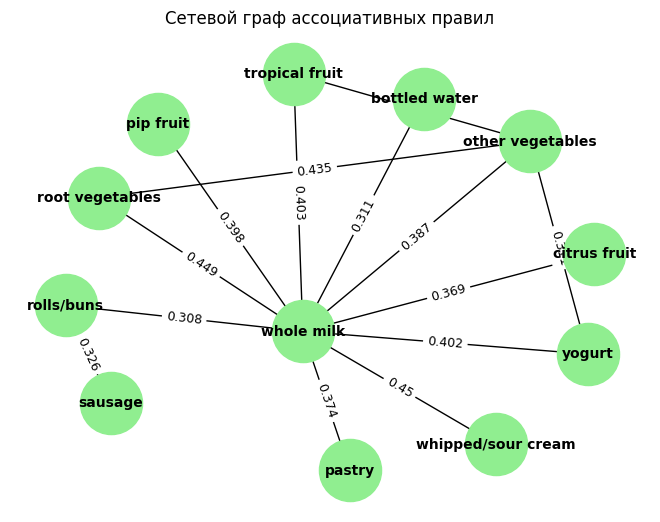

In [81]:
G = nx.Graph()


for index, row in rules_filtered.iterrows():
    ant = list(row['antecedents'])[0]
    con = list(row['consequents'])[0]
    conf = round(row['confidence'], 3)

    G.add_node(ant)
    G.add_node(con)
    G.add_edge(ant, con, weight=conf)

pos = nx.spring_layout(G, k=2)
nx.draw(G, pos, with_labels=True, node_size=2000, node_color='lightgreen', font_size=10, font_weight='bold')

edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)

plt.title('Сетевой граф ассоциативных правил')
plt.tight_layout()
plt.show()

Узлы графа это отдельные товары. Ребра между ними это значение достоверности. То есть например, если куплено whole milk, то с вероятностью 0.308 будут куплены rolls/buns.
На данном графе мы видем что молоко располагается в центре, что говорит о том что оно фигурирует во многих правилах и часто встречается в чеках.
## Альтернативный способ представления
График параллельных координат - каждая вертикальная ось это значение одной из метрик. Каждая линия правило, а ее положение по осям показывает, насколько это правило хорошо по данной метрики. 

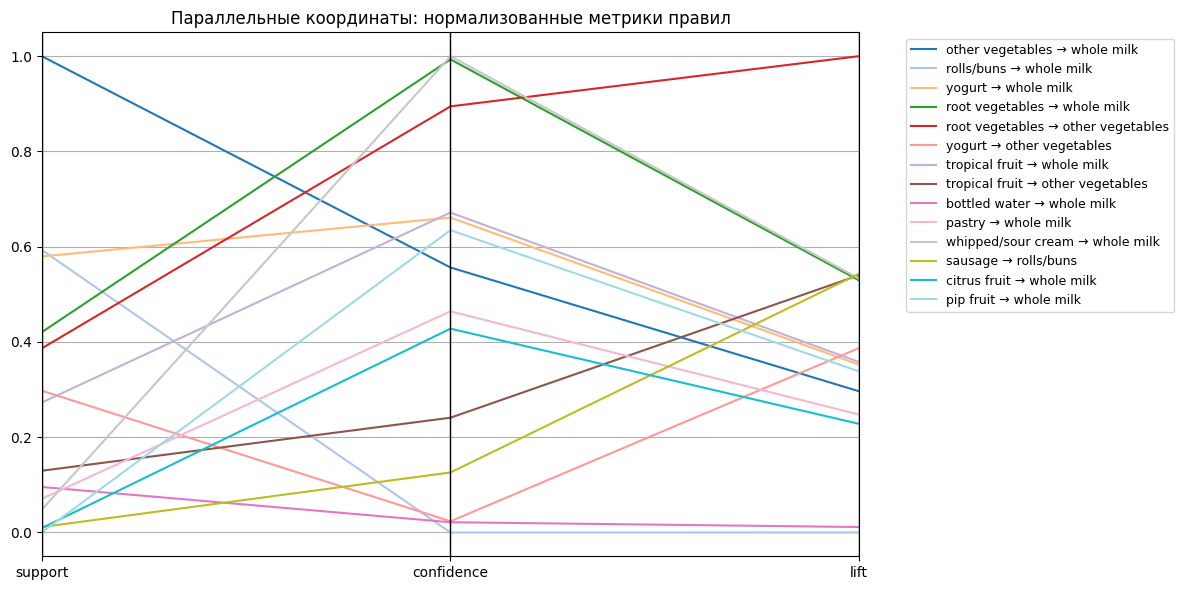

In [82]:
from pandas.plotting import parallel_coordinates
import matplotlib.pyplot as plt

df_plot = rules_filtered[['support', 'confidence', 'lift']].copy()
df_plot = (df_plot - df_plot.min()) / (df_plot.max() - df_plot.min())
df_plot['rule'] = rules_filtered['rule_str']

top_n = 20
df_plot = df_plot.head(top_n)

plt.figure(figsize=(12, 6))
parallel_coordinates(
    df_plot,
    'rule',
    colormap='tab20'
)
plt.title('Параллельные координаты: нормализованные метрики правил')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.tight_layout()
plt.show()

## Выводы
В результате лабораторной работы был проведен анализ датасета с транзакциями из магазина. В результате анализа методами FPG и Apriori были построены ассоциативные правила, которые показали закономерности в совместной покупки определенных групп товаров например, root vegatables и whole milk. Также был проведен эксперимент с измененением параметров min_support и min_confidance для метода Apriori. Он показал, что с уменьшением минимального уровня поддержки у нас появляются более длинные цепочки товаров, но падает lift для таких последовательностей, а следовательно они менее надежны. Также была проведена визуализация правил двумя методами: сетевым графом и параллельными координатами.